In [5]:
!pip3 install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 239.4 MB 1.1 MB/s eta 0:00:012     |███████████████████████████▊    | 207.5 MB 1.1 MB/s eta 0:00:29
     |████████████████████████████████| 71 kB 2.5 MB/s  eta 0:00:01
     |████████████████████████████████| 11.1 MB 20.2 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 16.2 MB/s eta 0:00:01
     |████████████████████████████████| 25.8 MB 11.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 20.9 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 13.4 MB/s eta 0:00:01
     |████████████████████████████████| 396 kB 20.8 MB/s eta 0:00:01
     |████████████████████████████████| 414 kB 18.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 27.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 15.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 41.0 MB/s eta 0:00:01
     |█████████████████

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Sample dataset
data = {
    'Team': ['Alavés', 'Athletic Bilbao', 'Atlético Madrid', 'Barcelona', 'Celta Vigo', 
             'Cádiz', 'Eibar', 'Elche', 'Espanyol', 'Getafe', 'Granada', 'Huesca', 
             'Levante', 'Mallorca', 'Osasuna', 'Rayo Vallecano', 'Real Betis', 
             'Real Madrid', 'Real Sociedad', 'Sevilla', 'Valencia', 'Valladolid', 
             'Villarreal'],
    'Pld': [76, 76, 76, 76, 76, 76, 38, 76, 38, 76, 76, 38, 76, 38, 76, 38, 76, 76, 76, 76, 76, 38, 76],
    'W': [17, 25, 47, 45, 26, 19, 6, 19, 10, 17, 21, 7, 17, 10, 23, 11, 36, 51, 34, 42, 21, 5, 31],
    'D': [18, 26, 16, 17, 21, 26, 12, 21, 12, 26, 21, 13, 25, 9, 22, 9, 18, 17, 22, 21, 28, 16, 24],
    'L': [41, 25, 13, 14, 29, 31, 20, 36, 16, 33, 34, 18, 34, 19, 31, 18, 22, 8, 20, 13, 27, 17, 21],
    'GF': [67, 89, 132, 153, 98, 71, 29, 74, 40, 61, 91, 34, 97, 36, 74, 39, 112, 147, 99, 106, 98, 34, 123],
    'GA': [122, 78, 68, 76, 100, 109, 52, 107, 53, 84, 126, 53, 133, 63, 99, 50, 90, 59, 75, 63, 106, 57, 81]
}

# Create DataFrame
df = pd.DataFrame(data)

# Step 1: Prepare the Data
X = df[['Pld', 'D', 'L', 'GF', 'GA']]  # Features
y = df['W']  # Target variable (Wins)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 2: Build the Neural Network
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer for regression

# Step 3: Compile the Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 4: Train the Model
model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

# Step 5: Evaluate the Model
predictions = model.predict(X_test)

# Combine predictions with team names
results = pd.DataFrame({'Team': df['Team'].iloc[y_test.index], 'Predicted Wins': predictions.flatten()})

# Sort results by predicted wins
results = results.sort_values(by='Predicted Wins', ascending=False)

# Display the results
print(results)

# Optionally, show the teams expected to win the most
print("\nTeams expected to win the most:")
print(results.head(10))

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

url1 = 'https://en.wikipedia.org/wiki/202'
url2 = '%E2%80%932'
url3 = '_La_Liga'

dataframes = []

for i in range(4):
    if(i == 2):
        break
    url = url1 + str(i) + url2 + str(i + 1) + url3
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    league_table_header = soup.find('h2', id='League_table')
    table = league_table_header.find_next('table')

    headers = ['Name', 'Test', 'TN']
    count = 0
    for th in table.find_all('th'):
        if(count < 10):
            headers.append(th.text.strip())
            count += 1

    data = []
    for row in table.find_all('tr'):
        cols = row.find_all(['td', 'a'])
        cols = [col.text.strip() for col in cols]
        data.append(cols)

    df = pd.DataFrame(data, columns=headers)
    df = df.rename(columns={'Teamvte': 'Team'})
    df = df.shift(axis=1, periods=3)
    df = df.drop(['Name', 'Test', 'TN'], axis=1)
    df = df.dropna()

    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)

numeric_columns = ['Pld', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts']
combined_df[numeric_columns] = combined_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

aggregated_df = combined_df.groupby('Team').agg({
    'Pld': 'sum',
    'W': 'sum',
    'D': 'sum',
    'L': 'sum',
    'GF': 'sum',
    'GA': 'sum'
}).reset_index()

print(aggregated_df)

aggregated_df.to_csv('la_liga_statistics.csv', index=False)


               Team  Pld   W   D   L   GF   GA
0            Alavés   76  17  18  41   67  122
1   Athletic Bilbao   76  25  26  25   89   78
2   Atlético Madrid   76  47  16  13  132   68
3         Barcelona   76  45  17  14  153   76
4        Celta Vigo   76  26  21  29   98  100
5             Cádiz   76  19  26  31   71  109
6             Eibar   38   6  12  20   29   52
7             Elche   76  19  21  36   74  107
8          Espanyol   38  10  12  16   40   53
9            Getafe   76  17  26  33   61   84
10          Granada   76  21  21  34   91  126
11           Huesca   38   7  13  18   34   53
12          Levante   76  17  25  34   97  133
13         Mallorca   38  10   9  19   36   63
14          Osasuna   76  23  22  31   74   99
15   Rayo Vallecano   38  11   9  18   39   50
16       Real Betis   76  36  18  22  112   90
17      Real Madrid   76  51  17   8  147   59
18    Real Sociedad   76  34  22  20   99   75
19          Sevilla   76  42  21  13  106   63
20         Va

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from bs4 import BeautifulSoup
import requests

In [51]:
url1 = 'https://en.wikipedia.org/wiki/202'
url2 = '%E2%80%932'
url3 = '_La_Liga'

for i in range(4):
    if(i == 2):
        break
    url = url1 + str(i) + url2 + str(i + 1) + url3
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    league_table_header = soup.find('h2', id='League_table')
    table = league_table_header.find_next('table')

    headers = ['Name', 'Test', 'TN']
    count = 0
    for th in table.find_all('th'):
        if(count < 10):
            headers.append(th.text.strip())
            count += 1

    data = []
    for row in table.find_all('tr'):
        cols = row.find_all(['td', 'a'])
        cols = [col.text.strip() for col in cols]
        data.append(cols)

    df = pd.DataFrame(data, columns=headers)
    df = df.rename(columns={'Teamvte': 'Team'})
    df = df.shift(axis=1, periods=3)
    df = df.drop(['Name', 'Test', 'TN'], axis=1)
    df = df.dropna()

    print(df)
#df.to_csv('la_liga_statistics.csv', index=False)

   Pos             Team Pld   W   D   L  GF  GA   GD    Pts
1    1  Atlético Madrid  38  26   8   4  67  25  +42     86
2    2      Real Madrid  38  25   9   4  67  28  +39     84
3    3        Barcelona  38  24   7   7  85  38  +47     79
4    4          Sevilla  38  24   5   9  53  33  +20     77
5    5    Real Sociedad  38  17  11  10  59  38  +21     62
6    6       Real Betis  38  17  10  11  50  50    0     61
7    7       Villarreal  38  15  13  10  60  44  +16     58
8    8       Celta Vigo  38  14  11  13  55  57   −2     53
9    9          Granada  38  13   7  18  47  65  −18  46[d]
10  10  Athletic Bilbao  38  11  13  14  46  42   +4  46[d]
11  11          Osasuna  38  11  11  16  37  48  −11  44[e]
12  12            Cádiz  38  11  11  16  36  58  −22  44[e]
13  13         Valencia  38  10  13  15  50  53   −3     43
14  14          Levante  38   9  14  15  46  57  −11     41
15  15           Getafe  38   9  11  18  28  43  −15     38
16  16           Alavés  38   9  11  18 

Fold 1 Accuracy: 0.98
Fold 1 Confusion Matrix:
[[0 0]
 [0 0]]

Fold 2 Accuracy: 1.00
Fold 2 Confusion Matrix:
[[0 0]
 [0 0]]

Fold 3 Accuracy: 0.98
Fold 3 Confusion Matrix:
[[0 0]
 [0 0]]

Fold 4 Accuracy: 0.80
Fold 4 Confusion Matrix:
[[0 0]
 [0 0]]

Fold 5 Accuracy: 0.96
Fold 5 Confusion Matrix:
[[0 0]
 [0 0]]

Average Accuracy: 0.94 (+/- 0.07)
Average Confusion Matrix:
[[0 0]
 [0 0]]

Feature Importance:
  feature  importance
1      ga    1.262633
0      gf    1.153731
3     sot    0.390351
5      fk    0.146649
2      sh    0.093052
7   pkatt    0.042728
4    dist    0.034067
6      pk    0.019074


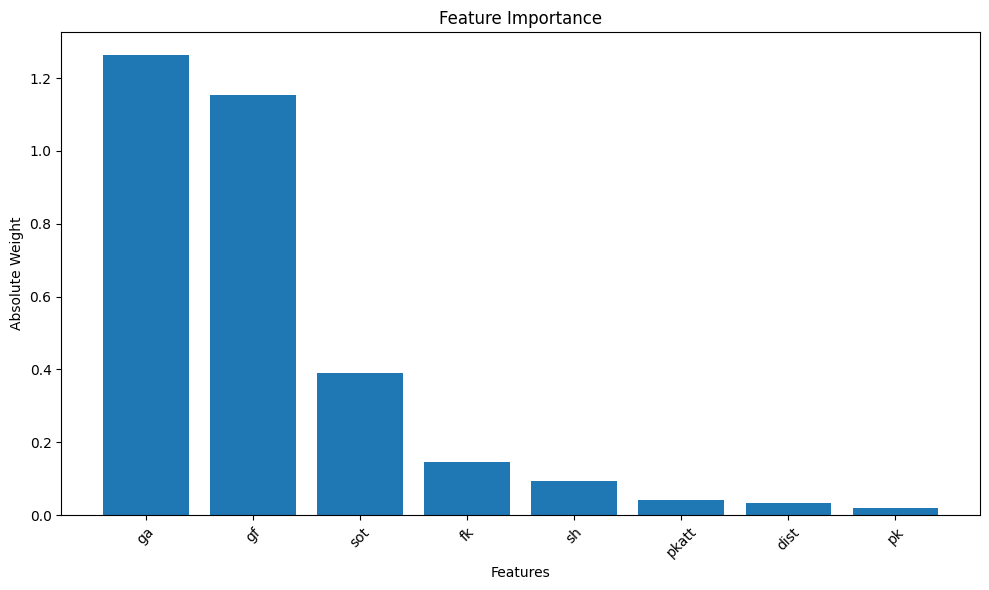


Team Performance:
team
Arsenal              0.736842
Manchester City      0.736842
Liverpool            0.631579
Aston Villa          0.526316
Tottenham Hotspur    0.526316
Chelsea              0.473684
Name: result, dtype: float64


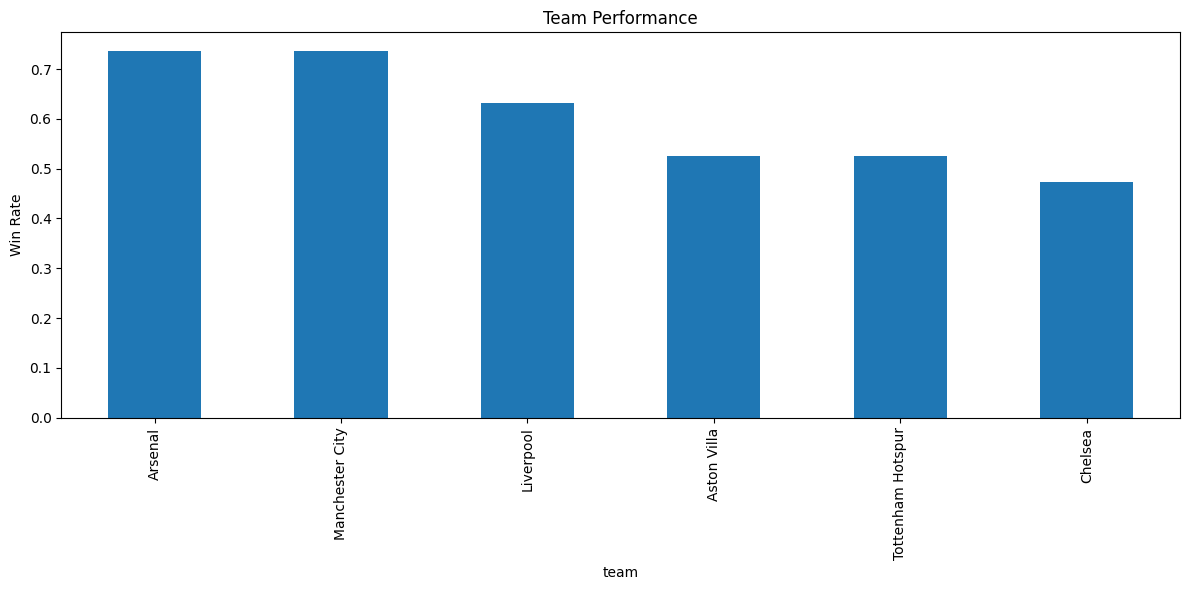

In [6]:
# Load the data
matches = pd.read_csv("matches.csv")

# Data preprocessing
matches['date'] = pd.to_datetime(matches['date'])
matches['result'] = matches['result'].map({'W': 1, 'D': 0, 'L': 0})  # Binary classification: win vs not win

# Feature selection
features = ['gf', 'ga', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt']
X = matches[features]
y = matches['result']

# Feature scaling
def scale_features(X):
    return (X - X.mean()) / X.std()

# Logistic Regression implementation
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0
        
        for _ in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)
            
            dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / num_samples) * np.sum(y_predicted - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_predicted]

# Evaluation metrics
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

# K-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
accuracies = []
confusion_matrices = []

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_scaled = scale_features(X_train)
    X_test_scaled = scale_features(X_test)
    
    model = LogisticRegression(learning_rate=0.01, num_iterations=1000)
    model.fit(X_train_scaled.values, y_train.values)
    
    y_pred = model.predict(X_test_scaled.values)
    
    acc = accuracy(y_test.values, y_pred)
    cm = confusion_matrix(y_test.values, y_pred)
    
    accuracies.append(acc)
    confusion_matrices.append(cm)
    
    print(f"Fold {fold} Accuracy: {acc:.2f}")
    print(f"Fold {fold} Confusion Matrix:")
    print(cm)
    print()

# Average results
print(f"Average Accuracy: {np.mean(accuracies):.2f} (+/- {np.std(accuracies):.2f})")
print("Average Confusion Matrix:")
print(np.mean(confusion_matrices, axis=0).astype(int))

# Train final model on all data
X_scaled = scale_features(X)
final_model = LogisticRegression(learning_rate=0.01, num_iterations=1000)
final_model.fit(X_scaled.values, y.values)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': np.abs(final_model.weights)
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Absolute Weight')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze team performance
team_performance = matches.groupby('team')['result'].mean().sort_values(ascending=False)
print("\nTeam Performance:")
print(team_performance)

# Visualize team performance
plt.figure(figsize=(12, 6))
team_performance.plot(kind='bar')
plt.title('Team Performance')
plt.ylabel('Win Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [63]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

url1 = 'https://en.wikipedia.org/wiki/202'
url2 = '%E2%80%932'
url3 = '_La_Liga'

# List to hold DataFrames
dataframes = []

for i in range(4):
    if(i == 2):
        break
    url = url1 + str(i) + url2 + str(i + 1) + url3
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    league_table_header = soup.find('h2', id='League_table')
    table = league_table_header.find_next('table')

    headers = ['Name', 'Test', 'TN']
    count = 0
    for th in table.find_all('th'):
        if(count < 10):
            headers.append(th.text.strip())
            count += 1

    data = []
    for row in table.find_all('tr'):
        cols = row.find_all(['td', 'a'])
        cols = [col.text.strip() for col in cols]
        data.append(cols)

    df = pd.DataFrame(data, columns=headers)
    df = df.rename(columns={'Teamvte': 'Team'})
    df = df.shift(axis=1, periods=3)
    df = df.drop(['Name', 'Test', 'TN'], axis=1)
    df = df.dropna()

    # Append the DataFrame to the list
    dataframes.append(df)

combined_df = pd.merge(dataframes[0], dataframes[1], on='Team')

new_df = pd.DataFrame()
new_df['Team'] = combined_df['Team']
new_df['Pld'] = combined_df['Pld_x'].astype(int) + combined_df['Pld_y'].astype(int)
new_df['W'] = combined_df['W_x'].astype(int) + combined_df['W_y'].astype(int)
new_df['D'] = combined_df['D_x'].astype(int) + combined_df['D_y'].astype(int)
new_df['L'] = combined_df['L_x'].astype(int) + combined_df['L_y'].astype(int)

# Display the aggregated DataFrame
print(new_df)

# Optionally, save to CSV
# aggregated_df.to_csv('aggregated_la_liga_statistics.csv', index=False)

               Team  Pld   W   D   L
0   Atlético Madrid   76  47  16  13
1       Real Madrid   76  51  17   8
2         Barcelona   76  45  17  14
3           Sevilla   76  42  21  13
4     Real Sociedad   76  34  22  20
5        Real Betis   76  36  18  22
6        Villarreal   76  31  24  21
7        Celta Vigo   76  26  21  29
8           Granada   76  21  21  34
9   Athletic Bilbao   76  25  26  25
10          Osasuna   76  23  22  31
11            Cádiz   76  19  26  31
12         Valencia   76  21  28  27
13          Levante   76  17  25  34
14           Getafe   76  17  26  33
15           Alavés   76  17  18  41
16            Elche   76  19  21  36
